<a href="https://colab.research.google.com/github/Neldev2000/NeuralNet/blob/master/MNIST_Classifier_Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from sklearn.datasets import fetch_openml

X,y = fetch_openml('mnist_784', version = 1, return_X_y = True)
y = y.astype(int)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [2]:
X.shape

(70000, 784)

[5 0 4 1 9 2 1 3 1 4]


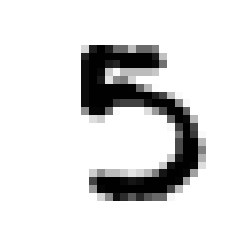

In [44]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36800]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,
           cmap = matplotlib.cm.binary,
           interpolation = 'nearest')
plt.axis('off')
print(y[:10])

## Split data into test and train sets

The data is already divided into train and test set. THe first 60,000 images are the training images and the other 10,000 are test ones 

In [0]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

Let's shuffle the training set, just to get a better distribution

In [0]:
import numpy as np

shuffle_index = np.random.permutation(60000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [47]:
y_train 

array([3, 0, 0, ..., 6, 5, 5])

# Training a Binary Classifier

To reduce the problem a little bit, we are going to train a binary classifier, it means, a model that predicts if some digit is in a certain group or not

In this example, we are going to predict if a digit is a 5 or not.

In [0]:
y_train_5 = y_train == 5
y_test_5  = y_test  == 5

The classifier we are gonna choose is the SGD Classifier because it is vert efficient with large datasets

In [51]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
sgd_clf.predict([some_digit])

array([ True])

##Performance Measures

### Measuring Accuracy with Cross-Validation

In [0]:
#Creating self cross-validation function for more control
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
def my_cross_val_score(model, train_set, train_labels, 
                       cv, random_state = 42):
  skfolds = StratifiedKFold(n_splits = cv, random_state  = random_state)
  
  results = []
  
  for train_index, test_index in skfolds.split(train_set, train_labels):
    clone_clf = clone(model)
    
    x_train_folds = train_set[train_index]
    y_train_folds = train_labels[train_index]
    
    x_test_fold = train_set[test_index]
    y_test_fold = train_labels[test_index]
    
    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    
    n_correct = sum( y_pred == y_test_fold )
    results.append( n_correct / len(y_pred) )
  return results
  

In [61]:
my_cross_val_score(sgd_clf, X_train, y_train_5, cv = 3)

[0.94645, 0.9646, 0.9584]

In [65]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5,
                cv = 3,
                scoring = 'accuracy')

array([0.94645, 0.9646 , 0.9584 ])

This accuracy is really impresive, over 90%. But ther's a trick.

Since our model just predict a true or false question, just by guessing we could get a really high accuracy, let's look at an example

In [66]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y = None):
    pass
  def predict(self, X):
    return np.zeros( (len(X), 1), dtype = bool)
  pass
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, 
               scoring = 'accuracy')

array([0.91065, 0.90635, 0.91195])

This confirms our prediction, without any training over the data we could get at least 90% of accuracy 

## Confusion Matrix

A better way to see good results is with the confusion matrix. This matrix (in a nutshell) shows how many elements have been classified correctly or wrongly. Based on four categories.


*   True Negative:   Elements that are correctly classified as non-five
*   False Negative: Elemtents which are five and were classified as non-five
*   False Positive:   Elements that are not five but were classified as 5
*   True Positive:    Elements that are five and wer ecorrectly classified as 5

![Confusion Matrix](https://revolution-computing.typepad.com/.a/6a010534b1db25970b01bb08c97955970d-pi)


To use the confusion matrix, we need a set of predictions, we can use 

```
cross_val_predict()

```
function to keep untouch the test set


In [0]:
from sklearn.model_selection import cross_val_predict

cross_val_predict?

In [0]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix?

In [72]:
confusion_matrix(y_train_5, y_train_pred)

array([[52750,  1829],
       [  782,  4639]])

We have:

*   True Negative (TN): 52,750
*   False Negative (FN): 782
*   False Positive (FP): 1,829
*   True Positive (TP): 4,639 



## Precision and Recall

There are two important measures to calculate the performance of the model


*   The Precision: It shows how many elements were correctly classified. Accuracy of positive predictions.
Formula: $Precision = \frac{TP}{TP+FP}$
*   The recall: It shows how likely is to find all the relevant cases in our prediction. It is also defined as the reatio of positive instances that are correctly classified. Formula: $Recall = \frac{TP}{TP + FN}$

An important thig about these two concepts is that the have both a tradeoff, if the precision increases then the recall decreases and vise-versa

In [73]:
from sklearn.metrics import precision_score, recall_score

print('Precision: {0:.4f}.\nRecall: {1:.4f}'.format( precision_score(y_train_5, y_train_pred),
                                                     recall_score(y_train_5, y_train_pred) ) )

Precision: 0.7172.
Recall: 0.8557


We can see that the model only predicts correctly the 71% of the time and it detects 85% of the 5s

Moreover, we can combine precision and recall into a single metric called the $F_{1}$ score. It is the harmonic mean of the precision and recall , and mathematically is defined as follows:

$F_{1} = \frac{2}{ \frac{1}{precision}+\frac{1}{recall} } = 2*\frac{precision*recall}{pecision + recall} = \frac{TP}{TP +\frac{FN + FP}{2}}$

In [75]:
from sklearn.metrics import f1_score

print('F1 score: {0:.4f}'.format( f1_score(y_train_5, y_train_pred) ))

F1 score: 0.7804


The $F_{1}$ score favors the classifiers that have similar precision and recall, but you may not want something like this. Sometimes you care a lot about precision and other times you care about recall


**Example:**  


1.   If you trained a classifier to detec videos that are good for kids, you may not want to predict good videos (low recall, low variety) but keep only safe ones (high precision)
2.   If you trained a classifier to detect shoplifter on surveillance images, it is probably fine if your classifier has only 30% of precision but it has 99% of recall


##The Precision/Recall Tradeoff

To understand this tradeoff, We must know how the SGDClassifier actually classifies a value.

What it does is compute a score based on a *decision function*, if that score is greater that some threshold, it classifies the value as positive, otherwise it is classified as negative.

If we increase the threshold, the precision increases (since we are selecting more carefully the elements) but the recall decreases  (since there is no a variety of elements). Now if we decrease the threshold, the oposite occurs; the recall increases but the precision decreases.

Scikit-Learn doesn't let you see the threshold directly, but is gives you access to the decision scores which uses to make predictions. You can call the 

```
decision_function()
```

method to get the decision scores and make predictions with the thresholds you want


In [77]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([4518.33479308])

In [80]:
threshold = 0
y_some_digit_predict = y_scores > threshold
y_some_digit_predict

array([ True])

In [81]:
threshold = 5000

y_some_digit_predict = y_scores > threshold
y_some_digit_predict

array([False])

You can see that increasing the threshold decreases the recall since 
```
some_digit
```
is a five but is misclassified as non-five



To decide which threshold to use, you can use again the 

```
cross_val_predict()
```
function but specifying that you want to return the decision scores insted of predictions


In [0]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, 
                             method = 'decision_function')

Now with the scores, you can compute the precision and reacll for all possible thresholds using the 

```
# Tiene formato de código
precision_recall_curve
```
function



In [0]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_train_5, y_scores)

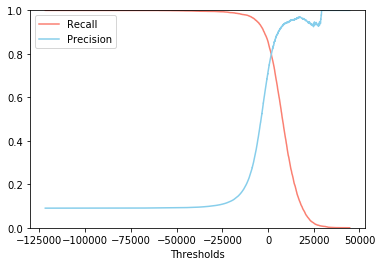

In [86]:
def plot_precision_recall_vs_thresholds(precision, recall, thresholds):
  plt.plot( thresholds, recall[:-1], c = 'salmon', label = 'Recall')
  plt.plot( thresholds, precision[:-1], c = 'skyblue', label = 'Precision' )
  plt.grid(False)
  plt.xlabel('Thresholds')
  plt.ylim([0,1])
  plt.legend()
  pass
plot_precision_recall_vs_thresholds(precision, recall, thresholds)
plt.show()

In [87]:
( precision.shape, recall.shape )

((59986,), (59986,))

Text(0, 0.5, 'Precision')

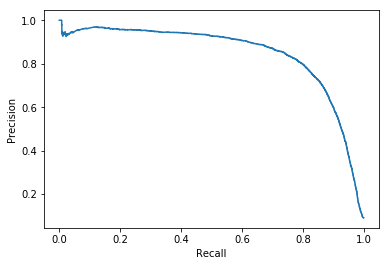

In [91]:
plt.plot( recall[:-1], precision[:-1] )
plt.xlabel('Recall')
plt.ylabel('Precision')